In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.stats

import os, sys

project_root = '/user_data/mmhender/featsynth/'
sys.path.insert(0, os.path.join(project_root, 'code'))
from utils import stats_utils, plot_utils

import get_gram_matrix_distances

figpath = os.path.join(project_root, 'figures_raw')

In [2]:
# load image info
image_set_name = 'images_things64'
image_list_filename = os.path.join(project_root, 'features','raw', '%s_list.csv'%(image_set_name))
labels = pd.read_csv(image_list_filename)

# figure out some image/category properties here
n_ims_each = np.sum(np.array(labels['basic_name'])==np.array(labels['basic_name'])[0])
basic_names = np.array(labels['basic_name'][0::n_ims_each])
super_names_long = np.array(labels['super_name'][0::n_ims_each])
basic_inds = np.array(labels['basic_index'][0::n_ims_each])
super_inds_long = np.array(labels['super_index'][0::n_ims_each])
n_basic = len(basic_names)
n_super = len(np.unique(super_names_long))
n_basic_each_super  = int(n_basic/n_super)
super_names = super_names_long[0::n_basic_each_super]
super_cbinds = np.repeat(np.array([0,1]), n_basic_each_super)
super_inds = np.arange(n_super)

# more image properties to organize images
image_type_names = ['orig']
n_image_types = len(image_type_names)
cue_level_names = ['basic','super']

#### get all the cosine distances

In [3]:
layer_names = ['pool1','pool2','pool3','pool4']
# layer_names = ['pool1']
n_layers = len(layer_names)

within_b, across_b_within_s, across_b_all, \
                within_s, across_s = [], [], [], [], []

within_b = np.zeros((n_basic, n_layers))
across_b_within_s = np.zeros((n_basic, n_layers))
across_b_all = np.zeros((n_basic, n_layers))
within_s = np.zeros((n_super, n_layers))
across_s = np.zeros((n_super, n_layers))

b_pair_dist = np.zeros((n_basic, n_basic, n_layers))
s_pair_dist = np.zeros((n_super, n_super, n_layers))

for ll in range(n_layers):
        
    wb, acb, acba, ws, acs, bp, sp = \
                    get_gram_matrix_distances.compute_distances_allims(image_set_name = image_set_name, \
                                                        distance_metric='cosine', \
                                                        layers_process = [layer_names[ll]], \
                                                        n_comp_keep = 100, \
                                                        # distance_metric='correlation', \
                                                       )

    within_b[:, ll] = wb
    across_b_within_s[:, ll] = acb
    across_b_all[:, ll] = acba
    within_s[:, ll] = ws
    across_s[:, ll] = acs

    b_pair_dist[:, :, ll] = bp
    s_pair_dist[:, :, ll] = sp
    

    

/user_data/mmhender/featsynth/features/gram_matrices/images_things64_gram_matrices_pool1_pca.npy
/user_data/mmhender/featsynth/features/gram_matrices/images_things64_gram_matrices_pool2_pca.npy
/user_data/mmhender/featsynth/features/gram_matrices/images_things64_gram_matrices_pool3_pca.npy
/user_data/mmhender/featsynth/features/gram_matrices/images_things64_gram_matrices_pool4_pca.npy


#### get ratio of across to within

In [4]:
basic_sep = across_b_within_s / within_b 
basic_sep_all = across_b_all / within_b 
super_sep_each_supcat = across_s / within_s

#### average across all the basic-level categs in each superordinate category

In [5]:
within_b_each_supcat = np.array([np.mean(within_b[super_inds_long==si,:], axis=0) \
                                for si in range(n_super)])
across_b_within_s_each_supcat = np.array([np.mean(across_b_within_s[super_inds_long==si,:], axis=0) \
                                for si in range(n_super)])
across_b_all_each_supcat = np.array([np.mean(across_b_all[super_inds_long==si,:], axis=0) \
                                for si in range(n_super)])


basic_sep_each_supcat = np.array([np.mean(basic_sep[super_inds_long==si,:], axis=0) \
                                   for si in range(n_super)])

basic_sep_all_each_supcat = np.array([np.mean(basic_sep_all[super_inds_long==si,:], axis=0) \
                                   for si in range(n_super)])

(8, 4)
[1.08502603 1.10791235 1.15499929 1.2955663 ] [0.03237829 0.03479937 0.04853743 0.09733904]
(8, 4)
[1.03440279 1.04429269 1.05202729 1.08806562] [0.01015229 0.01558185 0.02174216 0.04269297]
/user_data/mmhender/featsynth/figures_raw/things64_cosine_sep.pdf


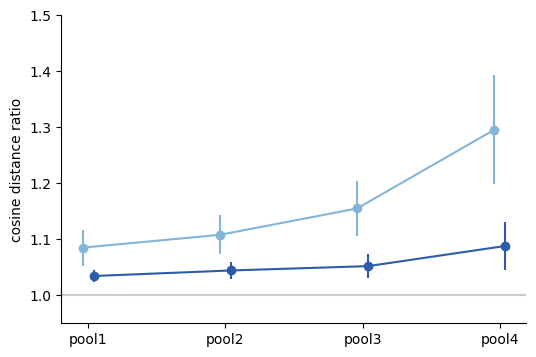

In [12]:
# level_colors = np.array([[93,192,219], [44,92,168]])/255
level_colors = np.array([[130, 181, 216], [44,92,168]])/255
level_names = ['Fine','Coarse']

# ni = 11;

lh = []

plt.rcParams['pdf.fonttype']=42

plt.figure(figsize=(6,4))
ax = plt.subplot(1,1,1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

jitters = [-0.04, 0.04]
    
# for cc, vals in enumerate([basic_sep[:,:,ni], super_sep_each_supcat[:,:,ni]]):
for cc, vals in enumerate([basic_sep_each_supcat, super_sep_each_supcat]):

    print(vals.shape)
    # for xi in range(vals.shape[0]):

    #     plt.plot(vals[xi,:], '-', color=level_colors[cc,:])
    m = np.mean(vals, axis=0)
    s = np.std(vals, axis=0)
    print(m, s)
    x = np.arange(vals.shape[1])+jitters[cc]
    h = plt.plot(x, m, 'o-', color=level_colors[cc,:])
    plt.errorbar(x, m, s, \
                 color=level_colors[cc,:], linestyle='none')
    
    lh+=[h[0]]

plt.xticks(np.arange(n_layers), layer_names)

# plt.legend(lh, level_names)

plt.axhline(1.0, color=[0.8, 0.8, 0.8])

plt.ylabel('cosine distance ratio')

# plt.title('category separability, %d images'%n_ims_vals[ni])

# plt.xlabel('layer')

plt.ylim([0.95, 1.5])

fn2save = os.path.join(figpath,'things64_cosine_sep.pdf')
print(fn2save)
plt.savefig(fn2save, transparent=True)

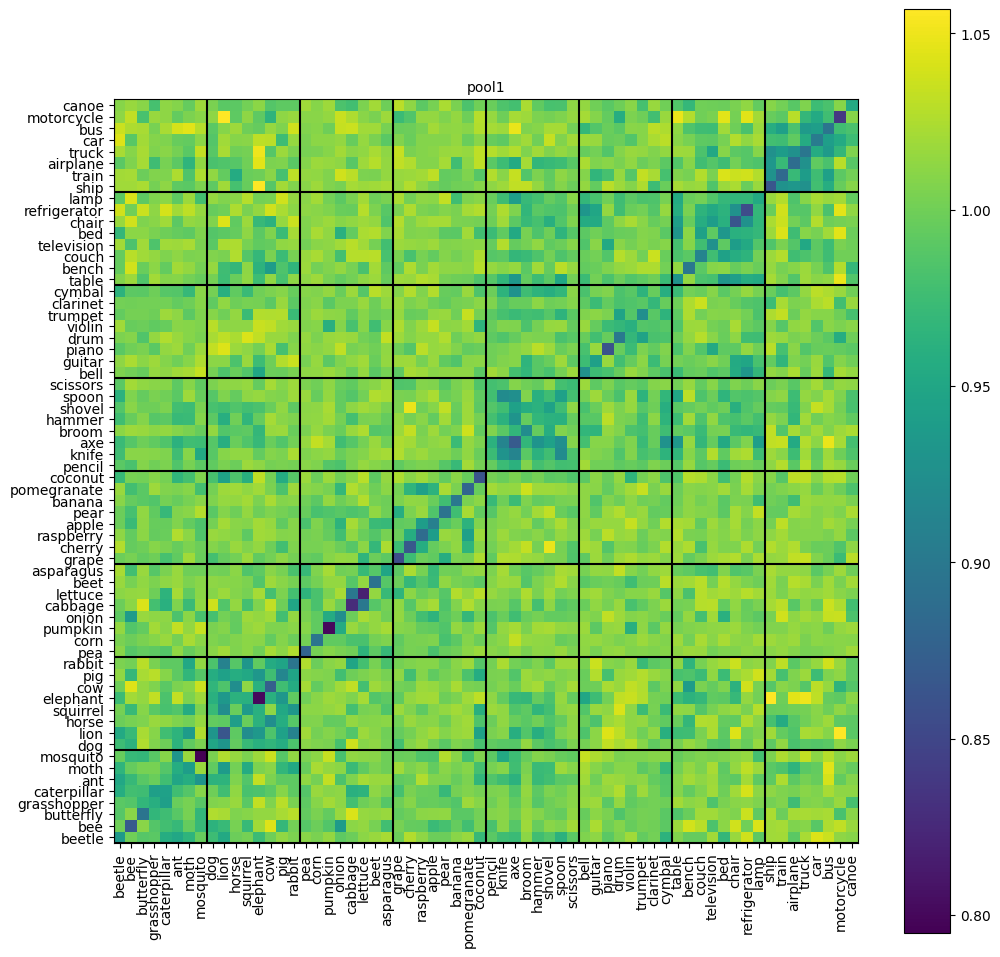

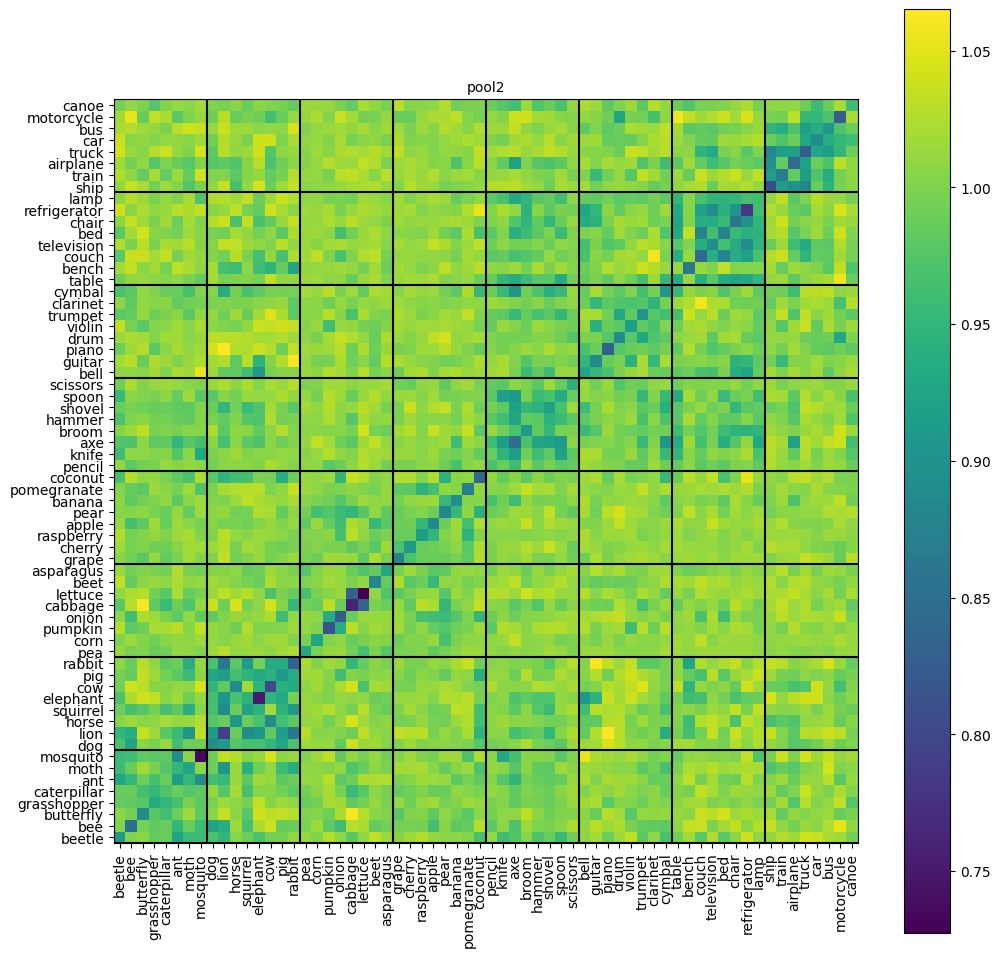

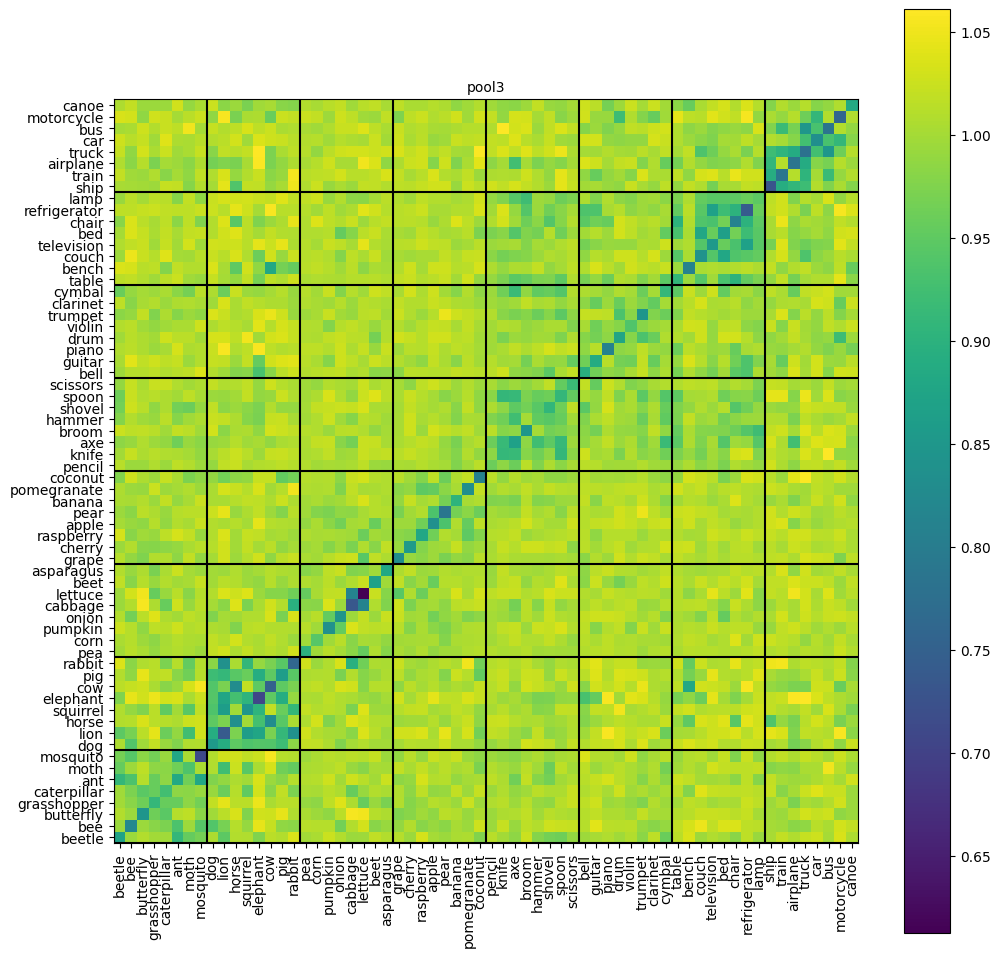

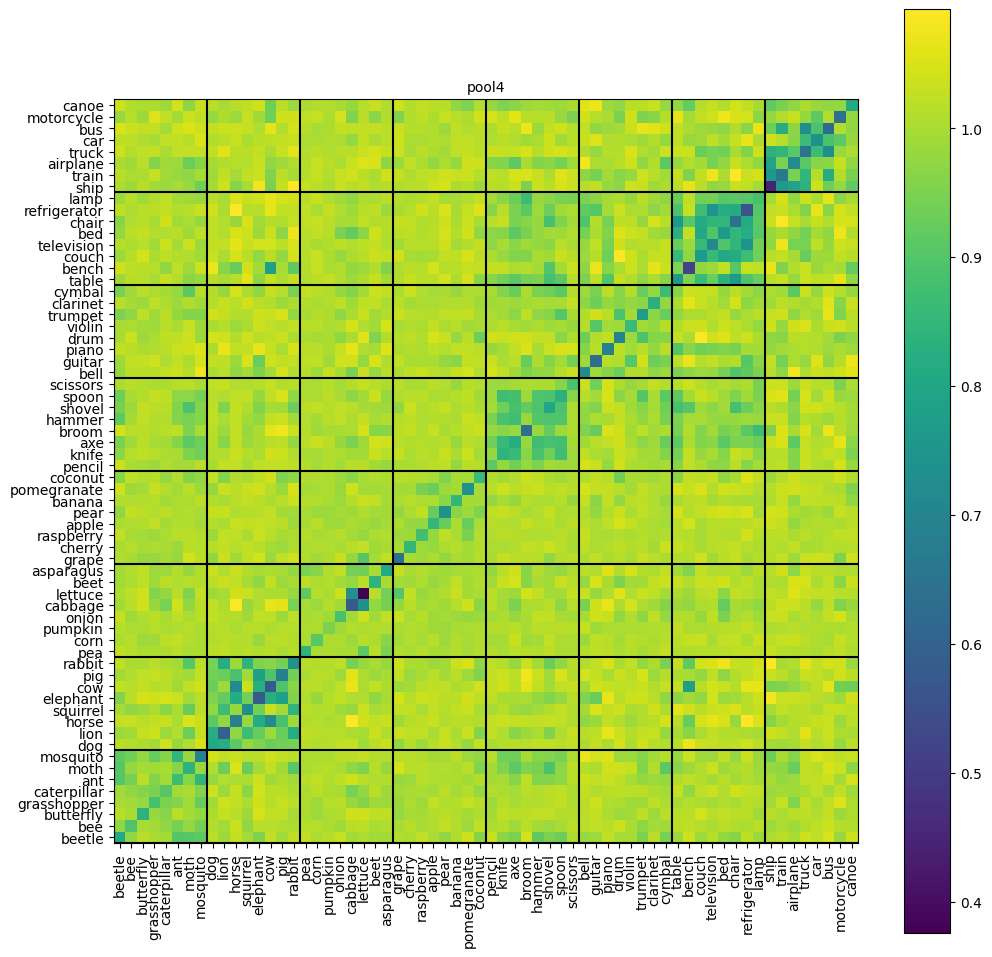

In [18]:
for ll in range(n_layers):
    
    
    d = b_pair_dist[:,:,ll]
    
    plt.figure(figsize=(12, 12))
    plt.pcolormesh(d, \
                   # vmin=0.37, vmax=1.10, \
                  )
    plt.xticks(np.arange(n_basic)+0.5, basic_names, rotation=90)
    plt.yticks(np.arange(n_basic)+0.5, basic_names)
    
    for si in range(n_super):
        plt.axhline(si*n_basic_each_super, color='k')
        plt.axvline(si*n_basic_each_super, color='k')
    
    plt.axis('square')
    plt.colorbar()

    plt.title(layer_names[ll])

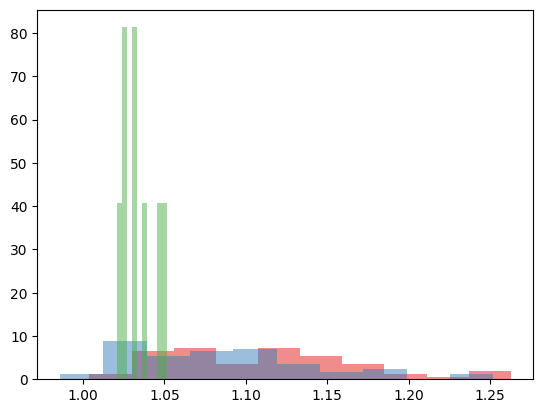

In [7]:
li = 0;

cue_level_colors = cm.Set1(np.linspace(0,1,9))[0:3,:]

plt.figure()

for vi, vals in enumerate([basic_sep_all[:,li], \
                         basic_sep[:,li], \
                         super_sep_each_supcat[:,li]]):
    
    plt.hist(vals, alpha=0.5, color=cue_level_colors[vi,:], density=True)
    
# plt.xlim([0.97, 2.2])

#### plot average separability of each type

(0.95, 1.5)

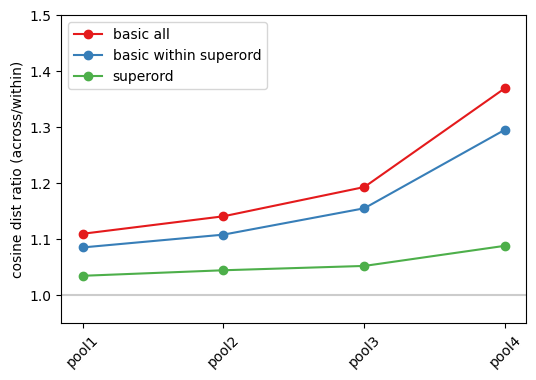

In [8]:
plot_utils.set_all_font_sizes(10)

xjitters =np.linspace(-0.05, 0.05, 3)

cue_level_colors = cm.Set1(np.linspace(0,1,9))[0:3,:]

point_types = ['o','x']
markersize = 4;


plt.figure(figsize=(6,4))

ax = plt.subplot(1,1,1)
    # lh = []

vals1 = np.mean(basic_sep_all, axis=0)
vals2 = np.mean(basic_sep, axis=0)
vals3 = np.mean(super_sep_each_supcat, axis=0)
levels = ['basic all','basic within superord','superord']

for cc, vals in enumerate([vals1, vals2, vals3]):

    h = plt.plot(np.arange(n_layers), vals,\
             'o-',color=cue_level_colors[cc,:])

    # lh.append(h[0])

    plt.xticks(np.arange(n_layers), layer_names,rotation=45)


# plt.axhline(0, color=[0.8, 0.8, 0.8], linestyle='--')

# ax.legend(lh, np.repeat(cue_level_vals,2), loc='lower right')
ax.legend(levels, loc='upper left')

plt.axhline(1.0, color=[0.8, 0.8, 0.8])

plt.ylabel('cosine dist ratio (across/within)')

plt.ylim([0.95, 1.5])




(0.95, 1.5)

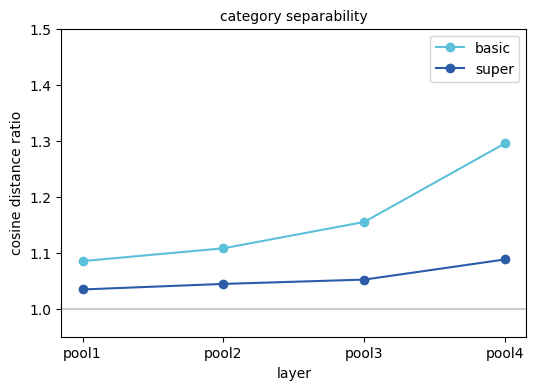

In [19]:
level_colors = np.array([[93,192,219], [44,92,168]])/255
level_names = ['basic','super']

lh = []

plt.figure(figsize=(6,4))
ax = plt.subplot(1,1,1)
    
for cc, vals in enumerate([basic_sep, super_sep_each_supcat]):

#     for xi in range(vals.shape[0]):

#         plt.plot(vals[xi,:], '-', color=level_colors[cc,:])
        
    h = plt.plot(np.mean(vals, axis=0), 'o-', color=level_colors[cc,:])
    
    lh+=[h[0]]

plt.xticks(np.arange(n_layers), layer_names)

plt.legend(lh, level_names)

plt.axhline(1.0, color=[0.8, 0.8, 0.8])

plt.ylabel('cosine distance ratio')

plt.title('category separability')

plt.xlabel('layer')

# plt.ylim([1.0, 1.15])
plt.ylim([0.95, 1.5])


Text(0.5, 1.0, 'things images')

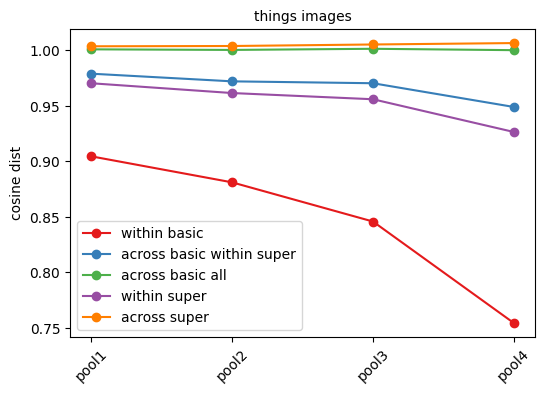

In [12]:
colors = cm.Set1(np.linspace(0,1,9))[0:5,:]

d = [within_b, across_b_within_s, across_b_all, within_s, across_s]
names = ['within basic','across basic within super','across basic all',\
         'within super', 'across super']

plot_utils.set_all_font_sizes(10)

xjitters =np.linspace(-0.05, 0.05, 3)

point_types = ['o','x']
markersize = 4;


plt.figure(figsize=(6,4))

ax = plt.subplot(1,1,1)
    # lh = []

for nn, dvals in enumerate(d):

    vals = np.mean(dvals, axis=0)
    
    h = plt.plot(np.arange(n_layers), vals,\
             'o-',color=colors[nn,:])

    # lh.append(h[0])

    plt.xticks(np.arange(n_layers), layer_names,rotation=45)


# plt.axhline(0, color=[0.8, 0.8, 0.8], linestyle='--')

# ax.legend(lh, np.repeat(cue_level_vals,2), loc='lower right')
ax.legend(names, loc='lower left')

plt.ylabel('cosine dist')

plt.title('things images')
# plt.ylim([1.0, 1.04])


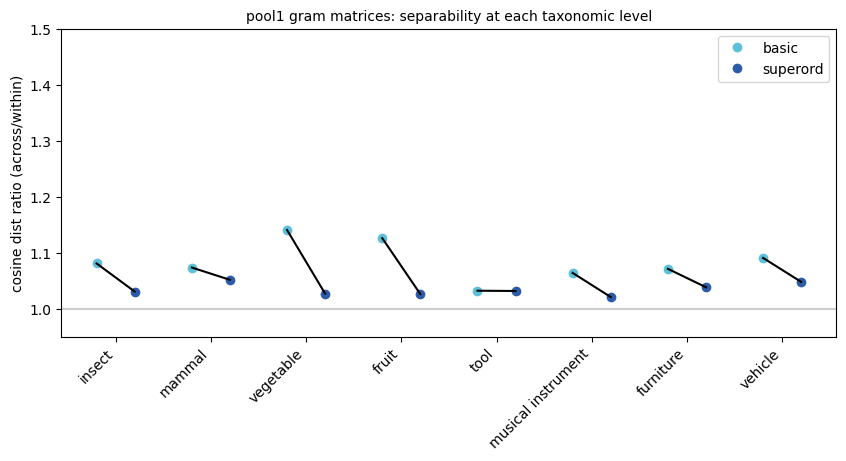

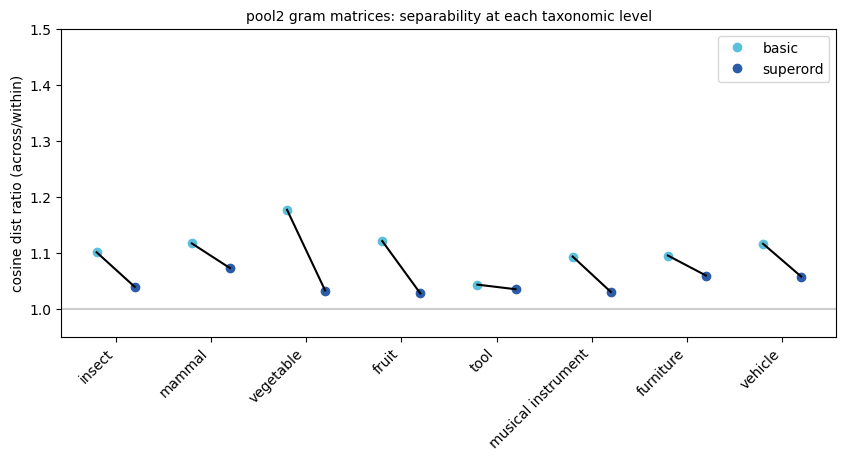

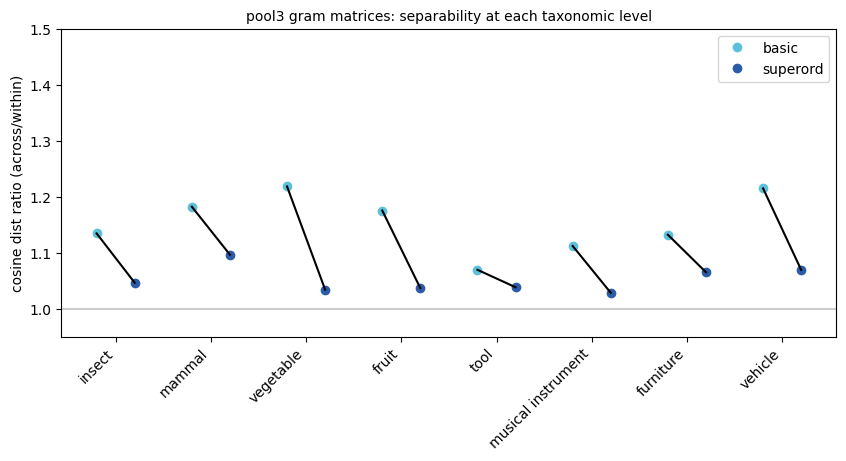

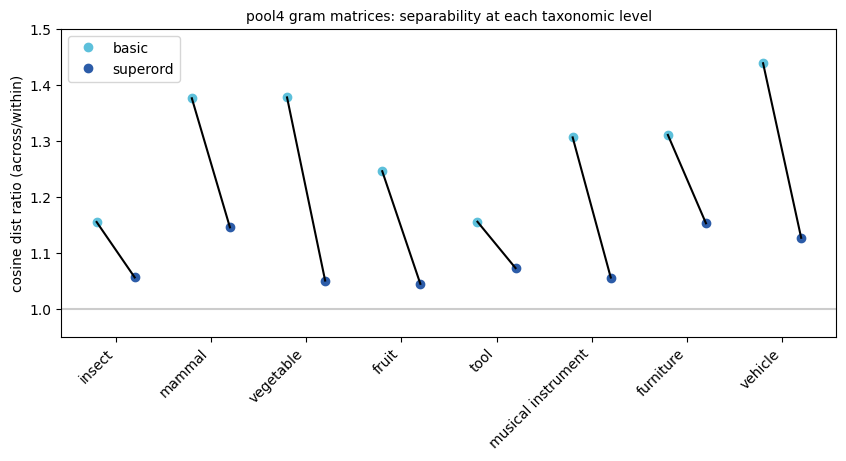

In [14]:
cue_level_colors = np.array([[93,192,219], [44,92,168]])/255


vals = np.array([basic_sep_each_supcat, super_sep_each_supcat])

xjitters = np.array([-0.2, 0.2])
barwidth = xjitters[1]*2

for ii in range(n_layers):
# for ii in range(4):
    
    
    plt.figure(figsize=(10,4))
    
    lh=[]
    for ca in range(n_super):
    
        for cc in range(2):
            h = plt.plot(ca+xjitters[cc], vals[cc,ca,ii], \
                    'o', color=cue_level_colors[cc,:])
            if ca==0:
                lh+=h
    
        plt.plot(ca+xjitters, vals[:,ca, ii], color='k')
    
    plt.xticks(np.arange(n_super), super_names, rotation=45, ha='right')
    
    plt.axhline(1, color=[0.8, 0.8, 0.8])
    
    plt.title('%s gram matrices: separability at each taxonomic level'%layer_names[ii])
    
    plt.legend(lh, ['basic','superord'])
    
    plt.ylabel('cosine dist ratio (across/within)')

    plt.ylim([0.95, 1.50])

#### separate into natural and artificial superord categories

In [16]:
is_natural = np.array([1,1,1,1,0,0,0,0]).astype(bool)
kind_names = ['Artificial','Natural']
n_kinds = len(kind_names)
nat_colors = cm.Greens(np.linspace(0,1,5))[[2,3],:]

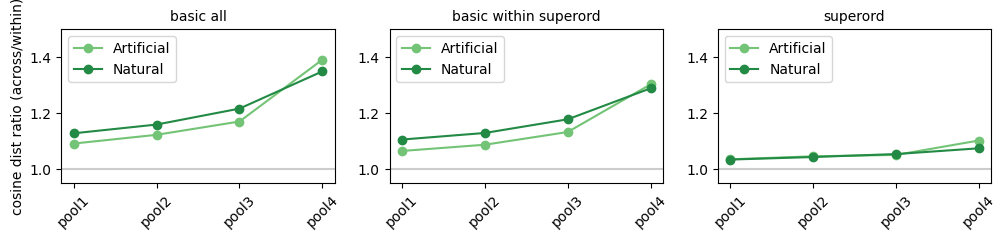

In [17]:
levels = ['basic all','basic within superord','superord']

plt.figure(figsize=(12,2))
pi=0

for vals, level in zip([basic_sep_all_each_supcat, \
                        basic_sep_each_supcat, \
                        super_sep_each_supcat], \
                      levels):
        
    pi+=1
    ax = plt.subplot(1,3,pi)
    
    lh = []
    
    for kk in [0,1]:
    
        meanvals = np.mean(vals[is_natural==kk,:], axis=0)
    
        h = plt.plot(np.arange(n_layers), meanvals, 'o-', color=nat_colors[kk,:])
    
        lh += h
        
    ax.legend(lh, kind_names, loc='upper left');
    plt.xticks(np.arange(n_layers), layer_names, rotation=45);

    plt.axhline(1, color=[0.8, 0.8, 0.8])
    
    if pi==1:
        plt.ylabel('cosine dist ratio (across/within)')
    
    plt.ylim([0.95, 1.50])
    
    plt.title(level)

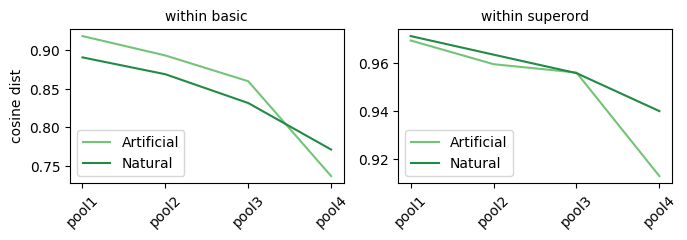

In [11]:
plt.figure(figsize=(12,2))
pi=0

levels = ['within basic','within superord']
for vals, level in zip([within_b_each_supcat, 
                        within_s], \
                      levels):
        
    pi+=1
    ax = plt.subplot(1,3,pi)
    
    lh = []
    
    for kk in [0,1]:
    
        meanvals = np.mean(vals[is_natural==kk,:], axis=0)
    
        h = plt.plot(np.arange(n_layers), meanvals, color=nat_colors[kk,:])
    
        lh += h
        
    ax.legend(lh, kind_names, loc='lower left');
    plt.xticks(np.arange(n_layers), layer_names, rotation=45);

    if pi==1:
        plt.ylabel('cosine dist')

    # plt.ylim([0.85, 1.0])
    # plt.ylim([1.0, 1.06])
    
    plt.title(level)

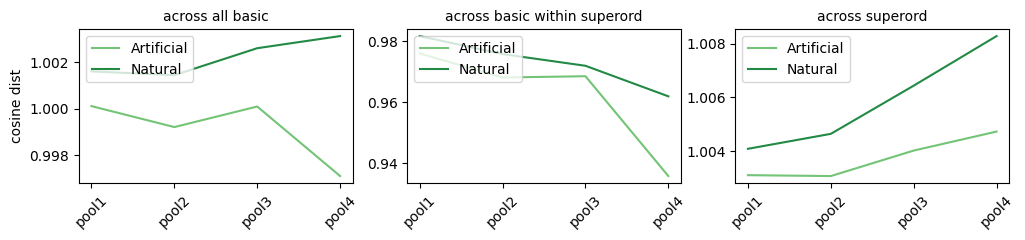

In [12]:
plt.figure(figsize=(12,2))
pi=0

levels = ['across all basic','across basic within superord', 'across superord']
for vals, level in zip([across_b_all_each_supcat,
                        across_b_within_s_each_supcat,
                        across_s], \
                      levels):
        
    pi+=1
    ax = plt.subplot(1,3,pi)
   
    lh = []
    
    for kk in [0,1]:
    
        meanvals = np.mean(vals[is_natural==kk,:], axis=0)
    
        h = plt.plot(np.arange(n_layers), meanvals, color=nat_colors[kk,:])
    
        lh += h
        
    ax.legend(lh, kind_names, loc='upper left');
    plt.xticks(np.arange(n_layers), layer_names, rotation=45);

    if pi==1:
        plt.ylabel('cosine dist')

    # plt.ylim([0.98, 1.005])
    # plt.ylim([1.0, 1.06])
    
    plt.title(level)

1.0065059480430416
0.004067485380138956
0.9264007293303325
0.03484659537051798
0.9489390262127588
0.04160828920151863
0.7542900985918031
0.12221490377650003


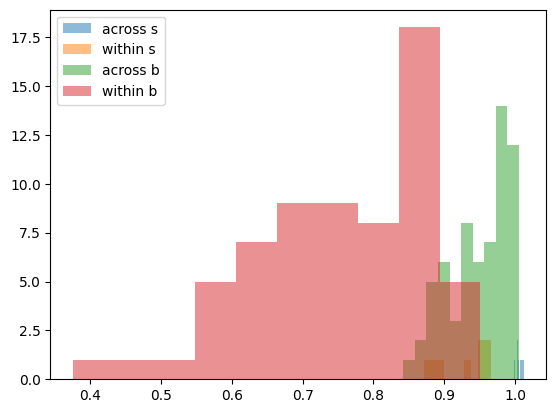

In [13]:
plt.figure()
ii = 3;
for vals in [across_s[:,ii], within_s[:,ii], across_b_within_s[:,ii], within_b[:,ii]]:

    print(np.mean(vals))
    print(np.std(vals))
    plt.hist(vals, alpha=0.5);

plt.legend(['across s','within s', 'across b', 'within b'])

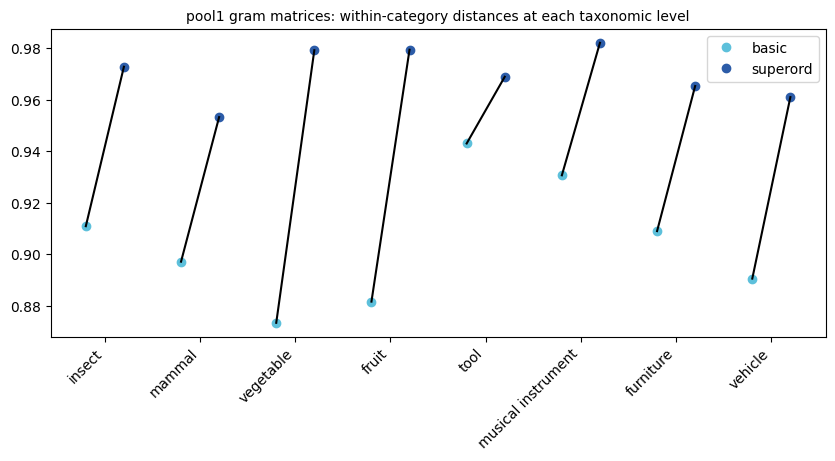

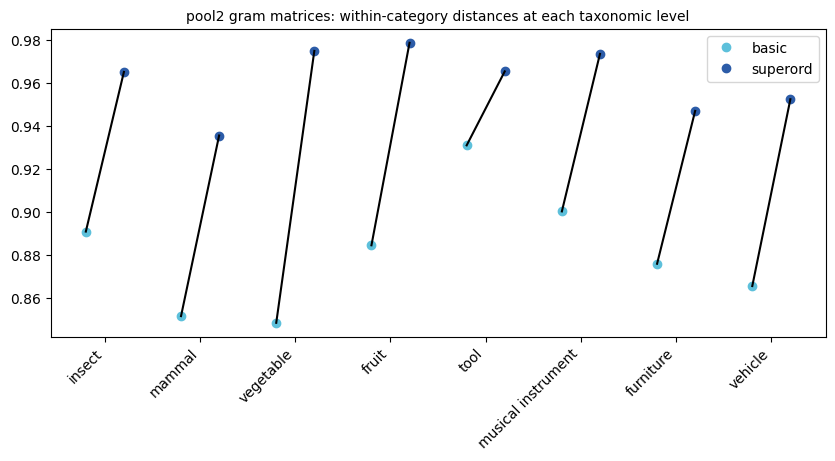

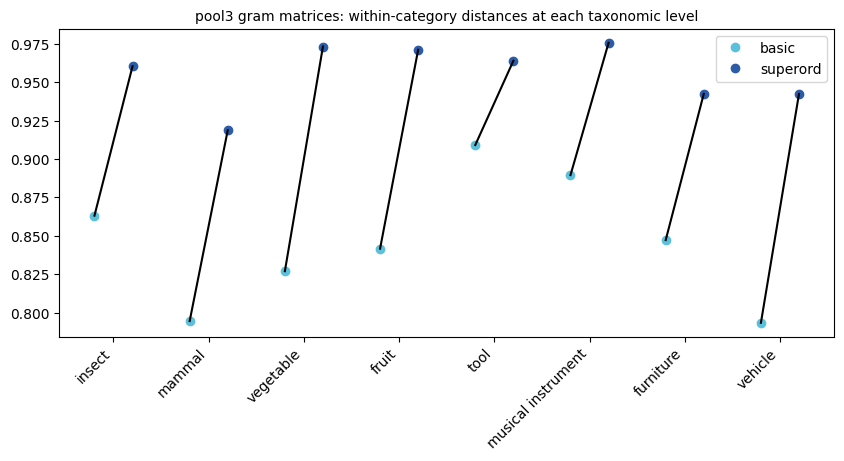

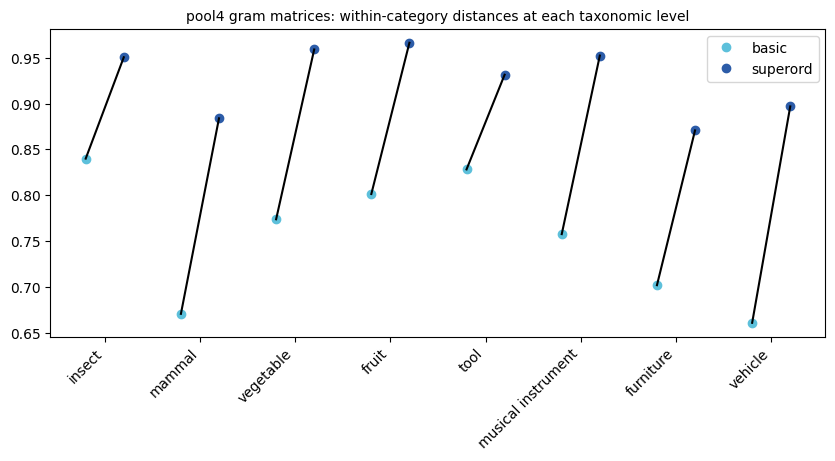

In [14]:
vals = np.array([within_b_each_supcat, within_s])
xjitters = np.array([-0.2, 0.2])
barwidth = xjitters[1]*2

for ii in range(4):

    
    plt.figure(figsize=(10,4))
    
    lh=[]
    for ca in range(n_super):
    
        for cc in range(2):
            h = plt.plot(ca+xjitters[cc], vals[cc,ca,ii], \
                    'o', color=cue_level_colors[cc,:])
            if ca==0:
                lh+=h
    
        plt.plot(ca+xjitters, vals[:,ca, ii], color='k')
    
    plt.xticks(np.arange(n_super), super_names, rotation=45, ha='right')
    
    # plt.axhline(1, color=[0.8, 0.8, 0.8])
    
    plt.legend(lh, ['basic','superord'])
    
    plt.title('%s gram matrices: within-category distances at each taxonomic level'%layer_names[ii])


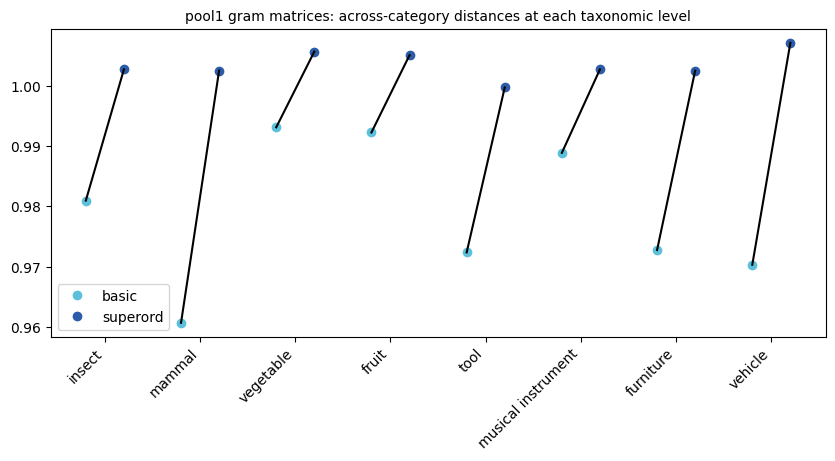

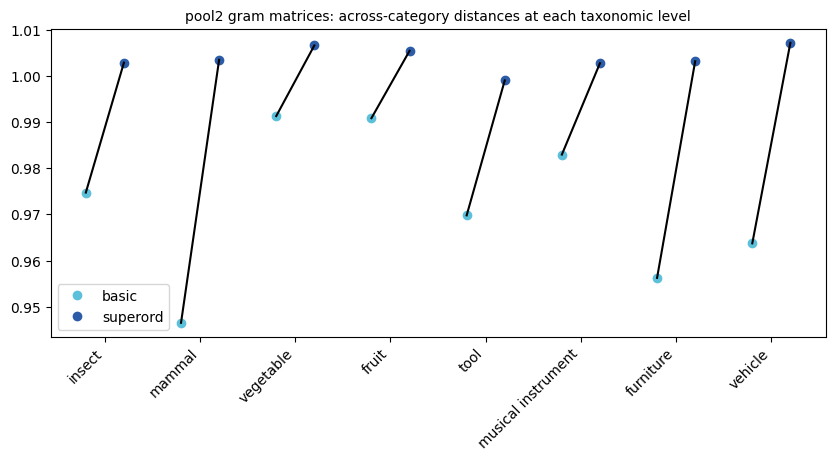

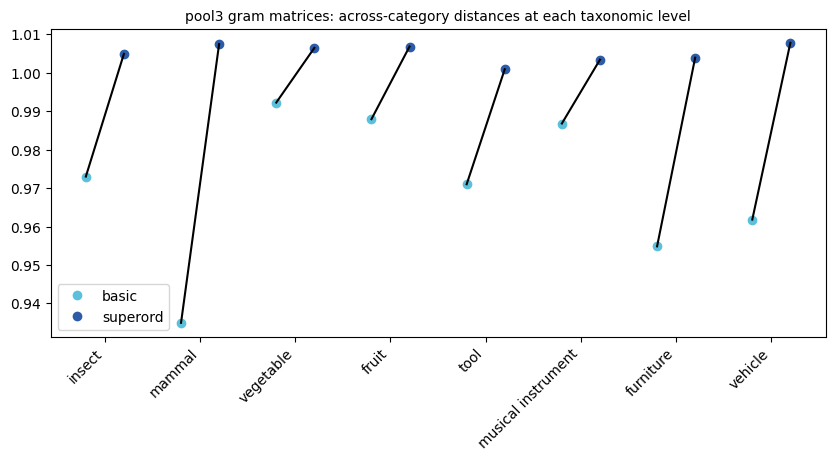

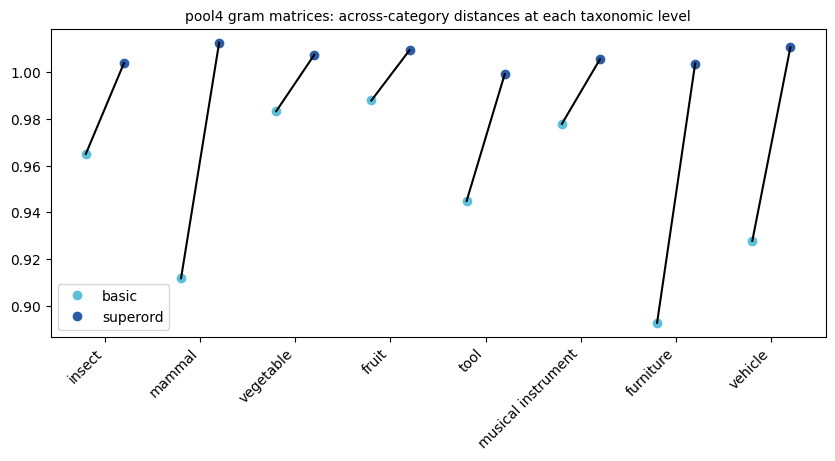

In [15]:
vals = np.array([across_b_within_s_each_supcat, across_s])

xjitters = np.array([-0.2, 0.2])
barwidth = xjitters[1]*2

for ii in range(4):
    
    plt.figure(figsize=(10,4))
    
    lh=[]
    for ca in range(n_super):
    
        for cc in range(2):
            h = plt.plot(ca+xjitters[cc], vals[cc,ca,ii], \
                    'o', color=cue_level_colors[cc,:])
            if ca==0:
                lh+=h
    
        plt.plot(ca+xjitters, vals[:,ca, ii], color='k')
    
    plt.xticks(np.arange(n_super), super_names, rotation=45, ha='right')
    
    # plt.axhline(1, color=[0.8, 0.8, 0.8])
    
    
    plt.legend(lh, ['basic','superord'])
    
    plt.title('%s gram matrices: across-category distances at each taxonomic level'%layer_names[ii])


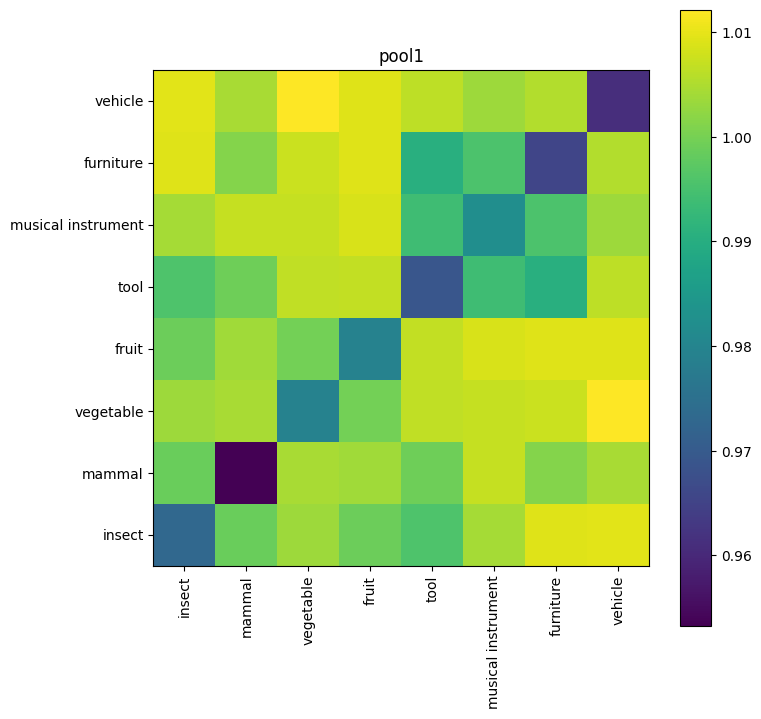

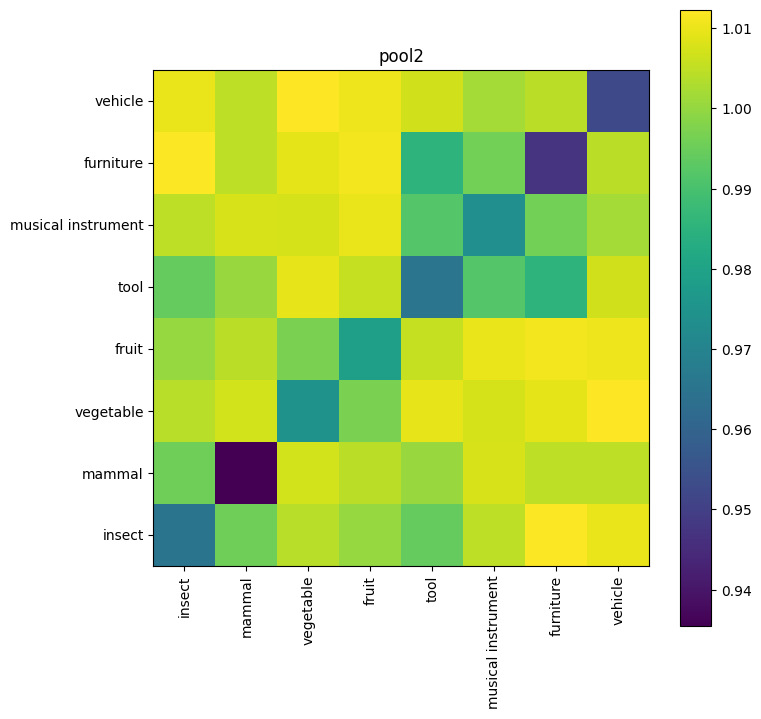

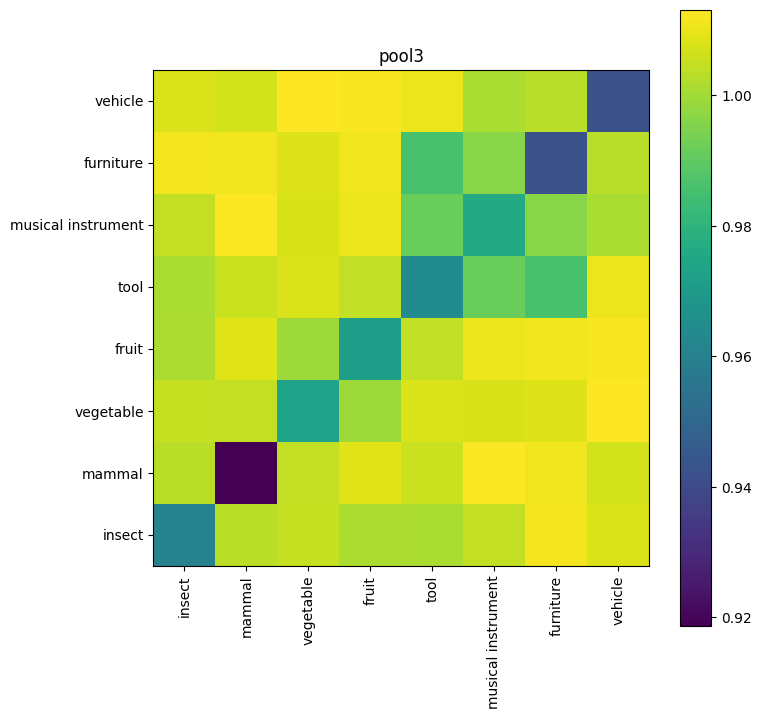

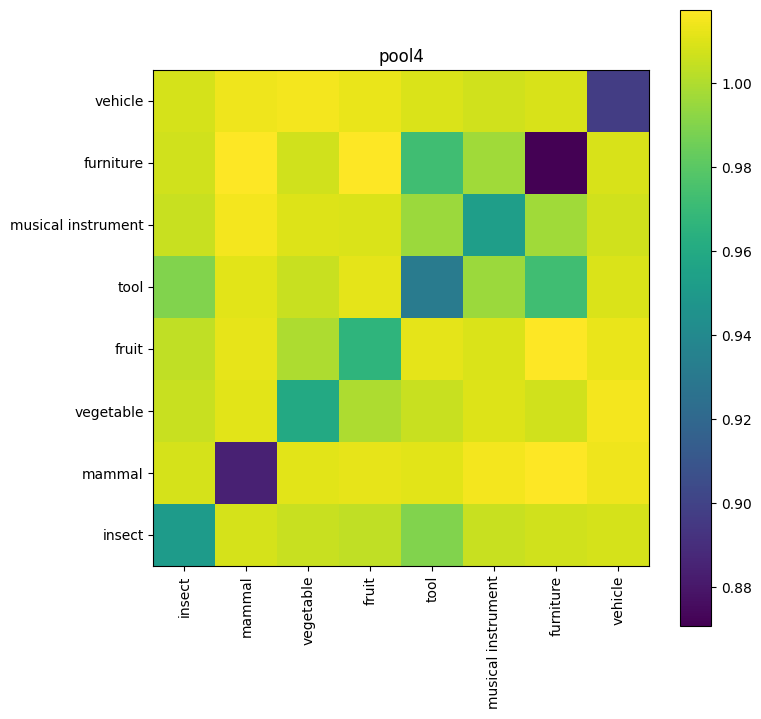

In [17]:
for ll in range(n_layers):
    
    
    d = s_pair_dist[:,:,ll]
    
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(d, \
                   # vmin=0.37, vmax=1.10, \
                  )
    plt.xticks(np.arange(n_super)+0.5, super_names, rotation=90)
    plt.yticks(np.arange(n_super)+0.5, super_names)
    
    # for si in range(n_super):
    #     plt.axhline(si*n_basic_each_super, color='k')
    #     plt.axvline(si*n_basic_each_super, color='k')
    
    plt.axis('square')
    plt.colorbar()

    plt.title(layer_names[ll])